<a href="https://colab.research.google.com/github/jianfeiZhao/BI_projs/blob/master/pm2_5_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use LSTM model to predict PM2.5 value of Beijing

In [3]:
# 将原始数据格式中的year, month, day, hour进行合并，并保存新的文件pollution.csv
from pandas import read_csv
from datetime import datetime
# 数据加载
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('./raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# 列名替换
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# 缺失值填充
dataset['pollution'].fillna(0, inplace=True)
# 去掉第一天数据（前24小时）
dataset = dataset[24:]
# 数据浏览
print(dataset.head(5))
# 数据保存
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [4]:
# 使用LSTM对PM2.5进行预测，根据8个特征维度预测PM指数 pollution
import pandas as pd
from pandas import read_csv, DataFrame, concat
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from itertools import chain

"""
将时间序列数据转换为适用于监督学习的数据
给定输入、输出序列的长度
data: 观察序列
n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1
n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
dropnan: 是否删除NaN行
返回值：适用于监督学习的 DataFrame
"""
# 将时间序列数据转换为适用于监督学习的数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# 数据加载
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
print(values)
print(values.shape)

[[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]
(43800, 8)


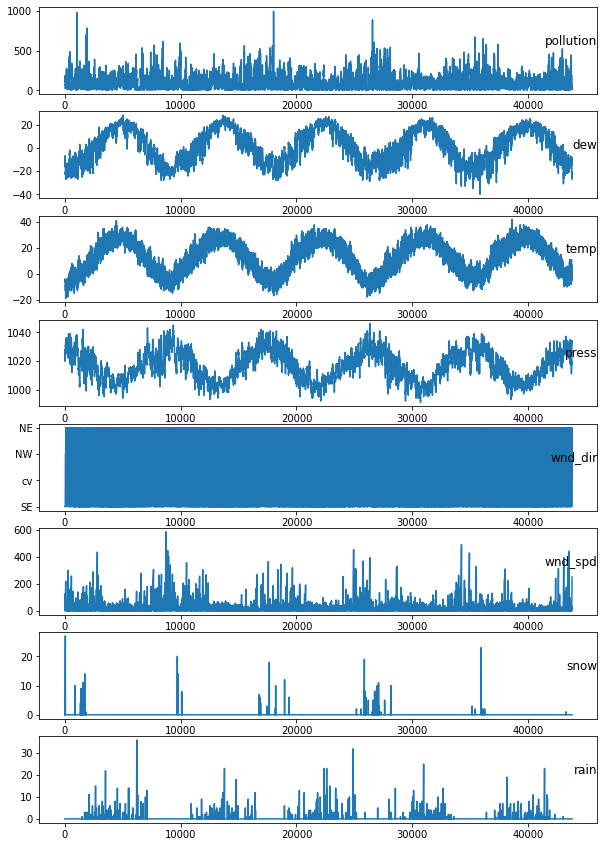

In [10]:
# 设置需要可视化的列表
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# 数据探索EDA
plt.figure(figsize=[10,15])
for group in range(8):
	plt.subplot(8, 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [16]:
# 将非数值类型特征wnd_dir进行标签编码
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# 设置数据类型均为flast32
values = values.astype('float32')
#pd.DataFrame(values).to_csv('values.csv')
print(values[:,4])

[2. 2. 2. ... 1. 1. 1.]


In [18]:
# 对所有数据进行0-1规范化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#print(scaled.shape)

# 将时间序列数据转换为适合监督学习的数据
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
#reframed.to_csv('reframed-1.csv')

# 去掉不需要预测的列，即var2(t)	var3(t)	var4(t)	var5(t)	var6(t)	var7(t)	var8(t)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#reframed.to_csv('reframed-2.csv')
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...   var6(t)   var7(t)  var8(t)
1   0.129779   0.352941   0.245902  ...  0.003811  0.000000      0.0
2   0.148893   0.367647   0.245902  ...  0.005332  0.000000      0.0
3   0.159960   0.426471   0.229508  ...  0.008391  0.037037      0.0
4   0.182093   0.485294   0.229508  ...  0.009912  0.074074      0.0
5   0.138833   0.485294   0.229508  ...  0.011433  0.111111      0.0

[5 rows x 16 columns]
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.129779   0.352941   0.245902  ...   0.000000        0.0  0.148893
2   0.148893   0.367647   0.245902  ...   0.000000        0.0  0.159960
3   0.159960   0.426471   0.229508  ...   0.000000        0.0  0.182093
4   0.182093   0.485294   0.229508  ...   0.037037        0.0  0.138833
5   0.138833   0.485294   0.229508  ...   0.074074        0.0  0.109658

[5 rows x 9 columns]


In [21]:
# 划分训练集80%，测试集20%
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# :-1表示从0到数组最后一位，-1表示数组最后一位
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape)

# 转换成3D格式 [样本数, 时间步, 特征数]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape)

(35039, 8)
(35039, 1, 8)


In [22]:
# 设置网络模型
model = Sequential()
# 一个时间步，八个特征
model.add(LSTM(output_dim=50, input_shape=(train_X.shape[1], train_X.shape[2]))) # 1,8
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 模型训练 
# verbose = 2 为每个epoch输出一行记录, =1为输出进度条记录, =0 不在标准输出流输出日志信息
result = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(1, 8), units=50)`
  after removing the cwd from sys.path.


Train on 35039 samples, validate on 8760 samples
Epoch 1/10
 - 7s - loss: 0.0021 - val_loss: 0.0023
Epoch 2/10
 - 5s - loss: 8.1073e-04 - val_loss: 0.0013
Epoch 3/10
 - 5s - loss: 8.1056e-04 - val_loss: 0.0012
Epoch 4/10
 - 5s - loss: 8.1395e-04 - val_loss: 0.0012
Epoch 5/10
 - 5s - loss: 8.1227e-04 - val_loss: 0.0012
Epoch 6/10
 - 5s - loss: 8.0971e-04 - val_loss: 0.0012
Epoch 7/10
 - 5s - loss: 8.0709e-04 - val_loss: 0.0012
Epoch 8/10
 - 5s - loss: 8.0469e-04 - val_loss: 0.0012
Epoch 9/10
 - 5s - loss: 8.0257e-04 - val_loss: 0.0012
Epoch 10/10
 - 5s - loss: 8.0073e-04 - val_loss: 0.0012


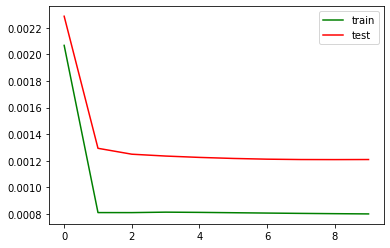

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# 模型预测
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# 绘制训练损失和测试损失
line1 = result.history['loss']
line2 = result.history['val_loss']
plt.plot(line1, label='train', c='g')
plt.plot(line2, label='test', c='r')
plt.legend(loc='best')
plt.show()
print(model.summary())

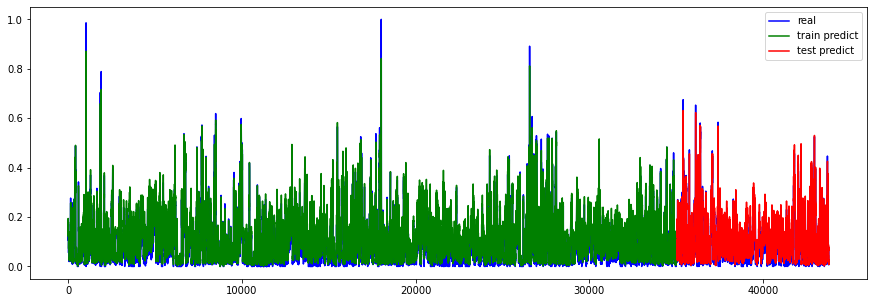

In [26]:
# 呈现原始数据，训练结果，预测结果
def plot_img(source_data_set, train_predict, test_predict):
    plt.figure(figsize=[15,5])
    # 原始数据蓝色
    plt.plot(source_data_set[:, -1], label='real', c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict], label='train predict', c='g')
    # 预测结果红色
    plt.plot([None for _ in train_predict] + [x for x in test_predict], label='test predict', c='r')
    plt.legend()
    plt.show()

# 绘制预测结果与实际结果对比
plot_img(values, train_predict, test_predict)